In [1]:
#TODO - function headers
#TODO - upload calc proof of KL Divergence
#TODO - implement dropout in encoder and decoder
#TODO - implement loops for arbitrary geometries in encoder and decoder

import tensorflow as tf
import flags
import ops
import data_utils
import numpy as np
from tensorflow.contrib.layers import l2_regularizer, fully_connected, flatten, batch_norm
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline 

In [2]:
class VariationalAutoEncoder():
    
    def __init__(self, image_shape, z_size, dtype=tf.float32):
        
        self.image_shape = image_shape # a list
        self.dtype = dtype
        self.z_size = z_size
    
    def encoder(self,
                X,
                init_depth=32,
                dropout_keep_prob=0.5,
                training=True):

        assert X.get_shape().as_list()[1:] == list(self.image_shape), "input shape (%s), ignoring batch_size, is different than expected shape %s" % (X.get_shape().as_list()[1:] , list(self.image_shape))
        assert X.dtype == self.dtype, "Unmatching datatypes"
        
        with tf.variable_scope("encoder"):
            
            #The first layer takes in an input image, and does a 5x5 convolution with it
            # this is then passed to a leaky relu
            h1 = ops.conv(X,
                         init_depth,
                         kernel=[5,5],
                         strides=[2,2],
                         w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                         regularizer=None,
                         name="e_conv_1")
            
            h1_a = ops.leaky_relu(h1, alpha=0.2)
            
            #if training and dropout_keep_prob > 0., do dropout
            
            h2 = ops.conv(h1_a,
                         init_depth*2,
                         kernel=[5,5],
                         strides=[2,2],
                         w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                         regularizer=None,
                         name="e_conv_2")
            
            h2_a = ops.leaky_relu(h2, alpha=0.2)
            
            #this input is now split into two separate fully_connected networks, one to output the
            # means, and one to output the standard deviations
            flat_h2 = flatten(h2_a)
            mu_out = fully_connected(flat_h2,
                                    self.z_size,
                                    activation_fn=None,
                                    weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                    weights_regularizer=None,
                                    scope="e_fc_3_1")
            
            sigma_out = fully_connected(flat_h2,
                                    self.z_size,
                                    activation_fn=None,
                                    weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                    weights_regularizer=None,
                                    scope="e_fc_3_2")
            
            return mu_out, sigma_out
    
    def decoder(self,
                X,
                init_depth=32,
                dropout_keep_prob=0.5,
                training=True):
        
        assert X.dtype == self.dtype, "Unmatching datatypes"
        
        with tf.variable_scope("decoder"):
            
            batch_size = X.get_shape().as_list()[0]
            
            #layer gets us prepared for the right dimensions to do two convolved transposes by taking a look
            #at the latent representation vector that was used to sample from the encoder outputs
            h1 = fully_connected(X,
                                (self.image_shape[0]//4) * (self.image_shape[1]//4) * init_depth,
                                activation_fn=None,
                                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                weights_regularizer=None,
                                scope="d_fc_1")
            h1_reshape = tf.reshape(h1, [batch_size, self.image_shape[0]//4, self.image_shape[1]//4, init_depth ])
            h1_a = tf.nn.relu(h1_reshape)
            
            #Layer two is the convolutional transpose and another relu
            h2 = ops.conv_transpose(h1_a,
                                   [batch_size, self.image_shape[0]//2, self.image_shape[1]//2, init_depth//2],
                                    kernel=[5,5],
                                    strides=[2,2],
                                    w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                    regularizer=None,
                                    name="d_conv_t_2")
            h2_a = tf.nn.relu(h2)
            
            #Layer two is the convolutional transpose and a sigmoid to give us pixels
            h3 = ops.conv_transpose(h2_a,
                                   [batch_size, self.image_shape[0], self.image_shape[1], self.image_shape[2]],
                                    kernel=[5,5],
                                    strides=[2,2],
                                    w_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                    regularizer=None,
                                    name="d_conv_t_3")
            return tf.sigmoid(h3)

    
    def train(self, train_X, batch_size, epochs):
        
        #TODO - migrate these elsewhere
        # stick in __init__ via vars(self).update(kwargs) for param names passed in flags
        # replace all these with self.these
        v_lr_init = 0.001
        v_lr_steps = 1000
        v_lr_decay = 1.0
        v_lr_min = 0.00001
        momentum = 0.9
        v_min_grad = -1.0
        v_max_grad = 1.0

        reg_loss_lambda = 0.001
        global_step = tf.Variable(0, trainable=False)
        
         #Create placeholder inputs for images, and separate the discriminator loss terms so that
        # we can investigate them separately
        assert list(train_X.shape[1:]) == list(self.image_shape), "Training set image size does not match expected class image size"
        
        #each training iteration makes use of training images and a random vector
        X_tr = tf.placeholder(self.dtype, shape=[batch_size] + list(self.image_shape) )
        
        #random noise
        z_sample = tf.placeholder(self.dtype, shape=[batch_size, self.z_size])
        
        #get unit gaussian from encoder network given the training images
        z_mean, z_stddev = self.encoder(X_tr)

        #Reparameterization - 
        #transform the sampled inputs by the mean and std vectors to get a sampled latent representation
        # in this way, we still have a differentiable and deterministic model, with injected stochasticity through
        # the random gaussian noise.
        z_latent = z_mean + (z_stddev *  z_sample) #these are all tensorflow tensors
                
        #generate images from decoder
        image_out = self.decoder(z_latent)
        
        #define a loss function based upon the output image.
        # the goal is to maximize the log-likelihood of the data under the model params,
        # that is p(x | theta_enc, theta_dec)
        #
        # We need to minimize -L, given that L is equal to the following
        # L(ϕ,θ;x) = E_z∼q_ϕ(z|x) [log(p_θ(x|z))]  −  KL-Divergence (q_ϕ (z|x) || p_θ (z))
        #
        #
        # The first term is the reconstruction error. How close the output to the input
        # In other words, what is the log likelihood of output x-hat given latent distribution z
        # This is easy, because we have a perfect function for this. CROSS ENTROPY!
        image_reconstruction_loss = ops.binary_cross_entropy(image_out, X_tr, name="reconstruction_loss")
        
        #the second term is the latent loss.
        # this means the kullback liebler divergece between the latent space representation
        # probability distribution and our prior.
        # in the equation above, q_ϕ (z|x) is the output of the encoder, and p_θ (z) is the continuous prior, 
        # this is intractable, so we say we want it to be a unit gaussian. this bias gives smooth interpolation
        
        # Here, we can use the analytical integration techniques of https://arxiv.org/pdf/1312.6114.pdf (appendix B)
        # − KL-Divergence (q_ϕ (z|x) || p_θ (z)) = integral [q_θ(z) (log p_θ(z) - log q_θ(z))] dz
        # - this will allow us to calculate this divergence analytically. the terms from the full integral drop out
        normal_distibution_mean = tf.zeros_like(z_mean)
        normal_distribution_stddev = tf.ones_like(z_stddev)
        
        latent_kl_divergence_loss = ops.univariate_gaussian_kl_divergence(z_mean,
                                                                          z_stddev,
                                                                          normal_distibution_mean,
                                                                          normal_distribution_stddev)
                
        #TODO - regularization loss here if it is wanted
        loss = tf.reduce_mean(image_reconstruction_loss + latent_kl_divergence_loss)
        
        #use an exponentially-decaying learning rate
        v_lr = tf.maximum(v_lr_min, tf.train.exponential_decay(v_lr_init, global_step, v_lr_steps, v_lr_decay, staircase=True))
        
        #adam optimizers work best for GAN's and VAE's
        opt = tf.train.AdamOptimizer(learning_rate=v_lr, beta1=momentum)
        
        #clip the gradients and apply them
        grads_vars = opt.compute_gradients(loss)
        grads_clipped = [(tf.clip_by_value(g, v_min_grad, v_max_grad), v) for g, v in grads_vars]
        train_op = opt.apply_gradients(grads_clipped, global_step=global_step)
        
        with tf.Session() as sess:
            
            self.sess = sess
            report_frequency = None #steps
            sess.run(tf.global_variables_initializer())
            
            print("Initialized session variables")

            iterations = int(train_X.shape[0] / batch_size)
            
            epoch_rec_losses = []
            epoch_kl_losses = []
            
            for epoch in range(epochs):
                
                #shuffle data per epoch
                print("Epoch %d / %d now training..." % (epoch+1, epochs))
                rec_losses = []
                kl_losses = []
                
                shuf = np.random.permutation(train_X.shape[0])
                train_X = train_X[shuf]

                for i in range(iterations):
                    
                    #next batch, TODO - remove overflow protection here
                    try:
                        x = train_X[ i*batch_size:(i+1)*batch_size, :, :, :]
                    except IndexError:
                        break
                    
                    #get gaussian noise with which to use in sampling the latent vector from the encoder
                    noise = np.random.normal(size=[batch_size, self.z_size])
                    
                    #run the network. wahoo! separate the losses so we can track them
                    rec_loss, kl_loss, _, total_loss = sess.run([image_reconstruction_loss, latent_kl_divergence_loss, train_op, loss], {X_tr: x, z_sample:noise})

                    rec_losses.append(np.mean(rec_loss))
                    kl_losses.append(np.mean(kl_loss))
                    
                    if report_frequency and i+1 % report_frequency == 0:
                        print("Epoch step %d - Rec-Loss: %f\t KL-Loss:%f") % (i+1, np.mean(rec_loss), np.mean(kl_loss))
                
                print("Epoch %d - Avg Rec-Loss: %f\t Avg KL-Loss:%f") % (i+1, np.mean(rec_losses), np.mean(kl_losses))
                epoch_rec_losses.append(np.mean(rec_losses))
                epoch_kl_losses.append(np.mean(kl_losses))
                
                print("Generated sample images from last batch of epoch:")
                noise2=np.random.normal(size=[batch_size, self.z_size])
                gen_img = sess.run(image_out, {X_tr: x, z_sample: noise2})
                self.show_samples(gen_img)
            
            self.show_losses(epoch_rec_losses, epoch_kl_losses)

    def show_samples(self, samples, n=25):
        
        sq_s = np.sqrt(n)
        assert samples.shape[0] >= n, "Num samples (%d) is larger than the number of samples passed to show_samples (%d)" % (n, samples.shape[0])
        assert round(sq_s)==sq_s, "Expected to show samples in an nxn grid. Pass a perfect square less than the sample size as n"
        sq_s = int(sq_s)
        
        gs = gridspec.GridSpec(sq_s, 2*sq_s)
        gs.update(wspace=0.2, hspace=0.2)
        
        for idx, sample in enumerate(samples):
            if idx > n-1:
                break
            ax = plt.subplot(gs[(idx % sq_s), int(idx / sq_s)])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(np.squeeze(sample), cmap='Greys_r')
        plt.show()
        
    def show_losses(self, d_losses, g_losses):
        pass

In [3]:
#Load the Dataset
FLAGS = tf.app.flags.FLAGS
batch_size = FLAGS.batch_size

(train_X, train_y), (_,_) = data_utils.load_dataset(FLAGS.dataset)
shuf = np.random.permutation(train_X.shape[0])
train_X = train_X[shuf]
train_y = train_y[shuf]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
my_VAE = VariationalAutoEncoder( train_X.shape[1:], 25)

Initialized session variables
Epoch 1 / 500 now training...
Epoch 468 - Avg Rec-Loss: 175.740341	 Avg KL-Loss:16.016811
Generated sample images from last batch of epoch:


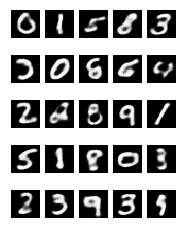

Epoch 2 / 500 now training...
Epoch 468 - Avg Rec-Loss: 91.679604	 Avg KL-Loss:24.816996
Generated sample images from last batch of epoch:


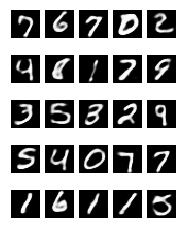

Epoch 3 / 500 now training...
Epoch 468 - Avg Rec-Loss: 84.917458	 Avg KL-Loss:26.148232
Generated sample images from last batch of epoch:


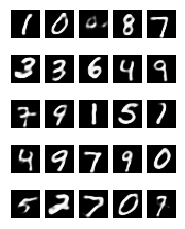

Epoch 4 / 500 now training...
Epoch 468 - Avg Rec-Loss: 81.969460	 Avg KL-Loss:26.366079
Generated sample images from last batch of epoch:


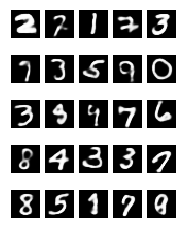

Epoch 5 / 500 now training...


KeyboardInterrupt: 

In [5]:
my_VAE.train(train_X, batch_size, 500)

In [ ]:
        return tf.reduce_sum( ( tf.log(sigma_2 / sigma_1) +\
                 ( tf.square(sigma_1) + tf.square(mu_1 - mu_2) ) / (2*tf.square(sigma_2)) - 0.5), 1)